### Import Libraries & Global Constants

In [50]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm as tqdm
# Seed for reproducibility
SEED = 42

### Load Data

In [51]:
# Load the data from the CSV file
df = pd.read_csv('../data/listings.csv')

## Data cleaning



In [ ]:
relevant_columns = ["accommodates", "bathrooms", "bedrooms", "longitude", "latitude", 
                    "host_listings_count", "minimum_nights", "number_of_reviews", 
                    "reviews_per_month", "host_identity_verified", "instant_bookable", 
                    "host_is_superhost", "price"]

def keep_columns(df, columns_to_keep):
    existing_columns = [col for col in columns_to_keep if col in df.columns]
    return df[existing_columns]

def clean_price(df):
    # First check that price is not already a numeric value
    if df['price'].dtype == np.float64:
        return df
    df_copy = df.copy()
    # Remove the commas and dollar signs from the price column
    df_copy['price'] = df_copy['price'].str.replace("$", "").str.replace(",", "").astype(float)
    return df_copy


def convert_boolean_columns(df):
    # Convert boolean columns to 0 and 1
    boolean_columns = df.select_dtypes(include='bool').columns
    df_copy = df.copy()
    for col in boolean_columns:
        df_copy[col] = df_copy[col].astype(int)

    # Needed since boolean data is inconsistent
    for col in df_copy.columns:
        if set(df_copy[col].unique()) == {'f', 't'}:
            df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
    return df_copy


def convert_percentage_to_decimal(percentage_str):
    try: 
        float(percentage_str)
        return 0
    except:    
        p = percentage_str.strip('%')
    
        return int(p) / 100

def fill_missing_values(df):
    df_copy = df.copy()
    #If type is numeric, fill with mean
    for col in df_copy.select_dtypes(include='number').columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    # Otherwise, if type is anything else, delete row
    df_copy = df_copy.dropna()

    return df_copy
    
def remove_outliers(df):
    df_copy = df.copy()
    
    df_copy = df_copy[df_copy['price'] < 6000]
    df_copy = df_copy[df_copy['reviews_per_month'] < 4]
    df_copy = df_copy[df_copy['host_listings_count'] < 15]
    df_copy = df_copy[df_copy["minimum_nights"] < 15]
    df_copy = df_copy[df_copy["number_of_reviews"] < 200]
    
    return df_copy

def z_score_outliers(df, threshold=3):
    df_copy = df.copy()
    z_scores = (df_copy - df_copy.mean()) / df_copy.std()
    return df_copy[(z_scores.abs() < threshold).all(axis=1)]




In [71]:
df_cleaned = df.copy()
df_cleaned = keep_columns(df_cleaned, relevant_columns)
df_cleaned = clean_price(df_cleaned)
df_cleaned = fill_missing_values(df_cleaned)
df_cleaned = convert_boolean_columns(df_cleaned)
df_cleaned = remove_outliers(df_cleaned)




/var/folders/g3/2wc_x03s0fv00j7h4xdv15y80000gn/T/ipykernel_4329/1638854588.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})


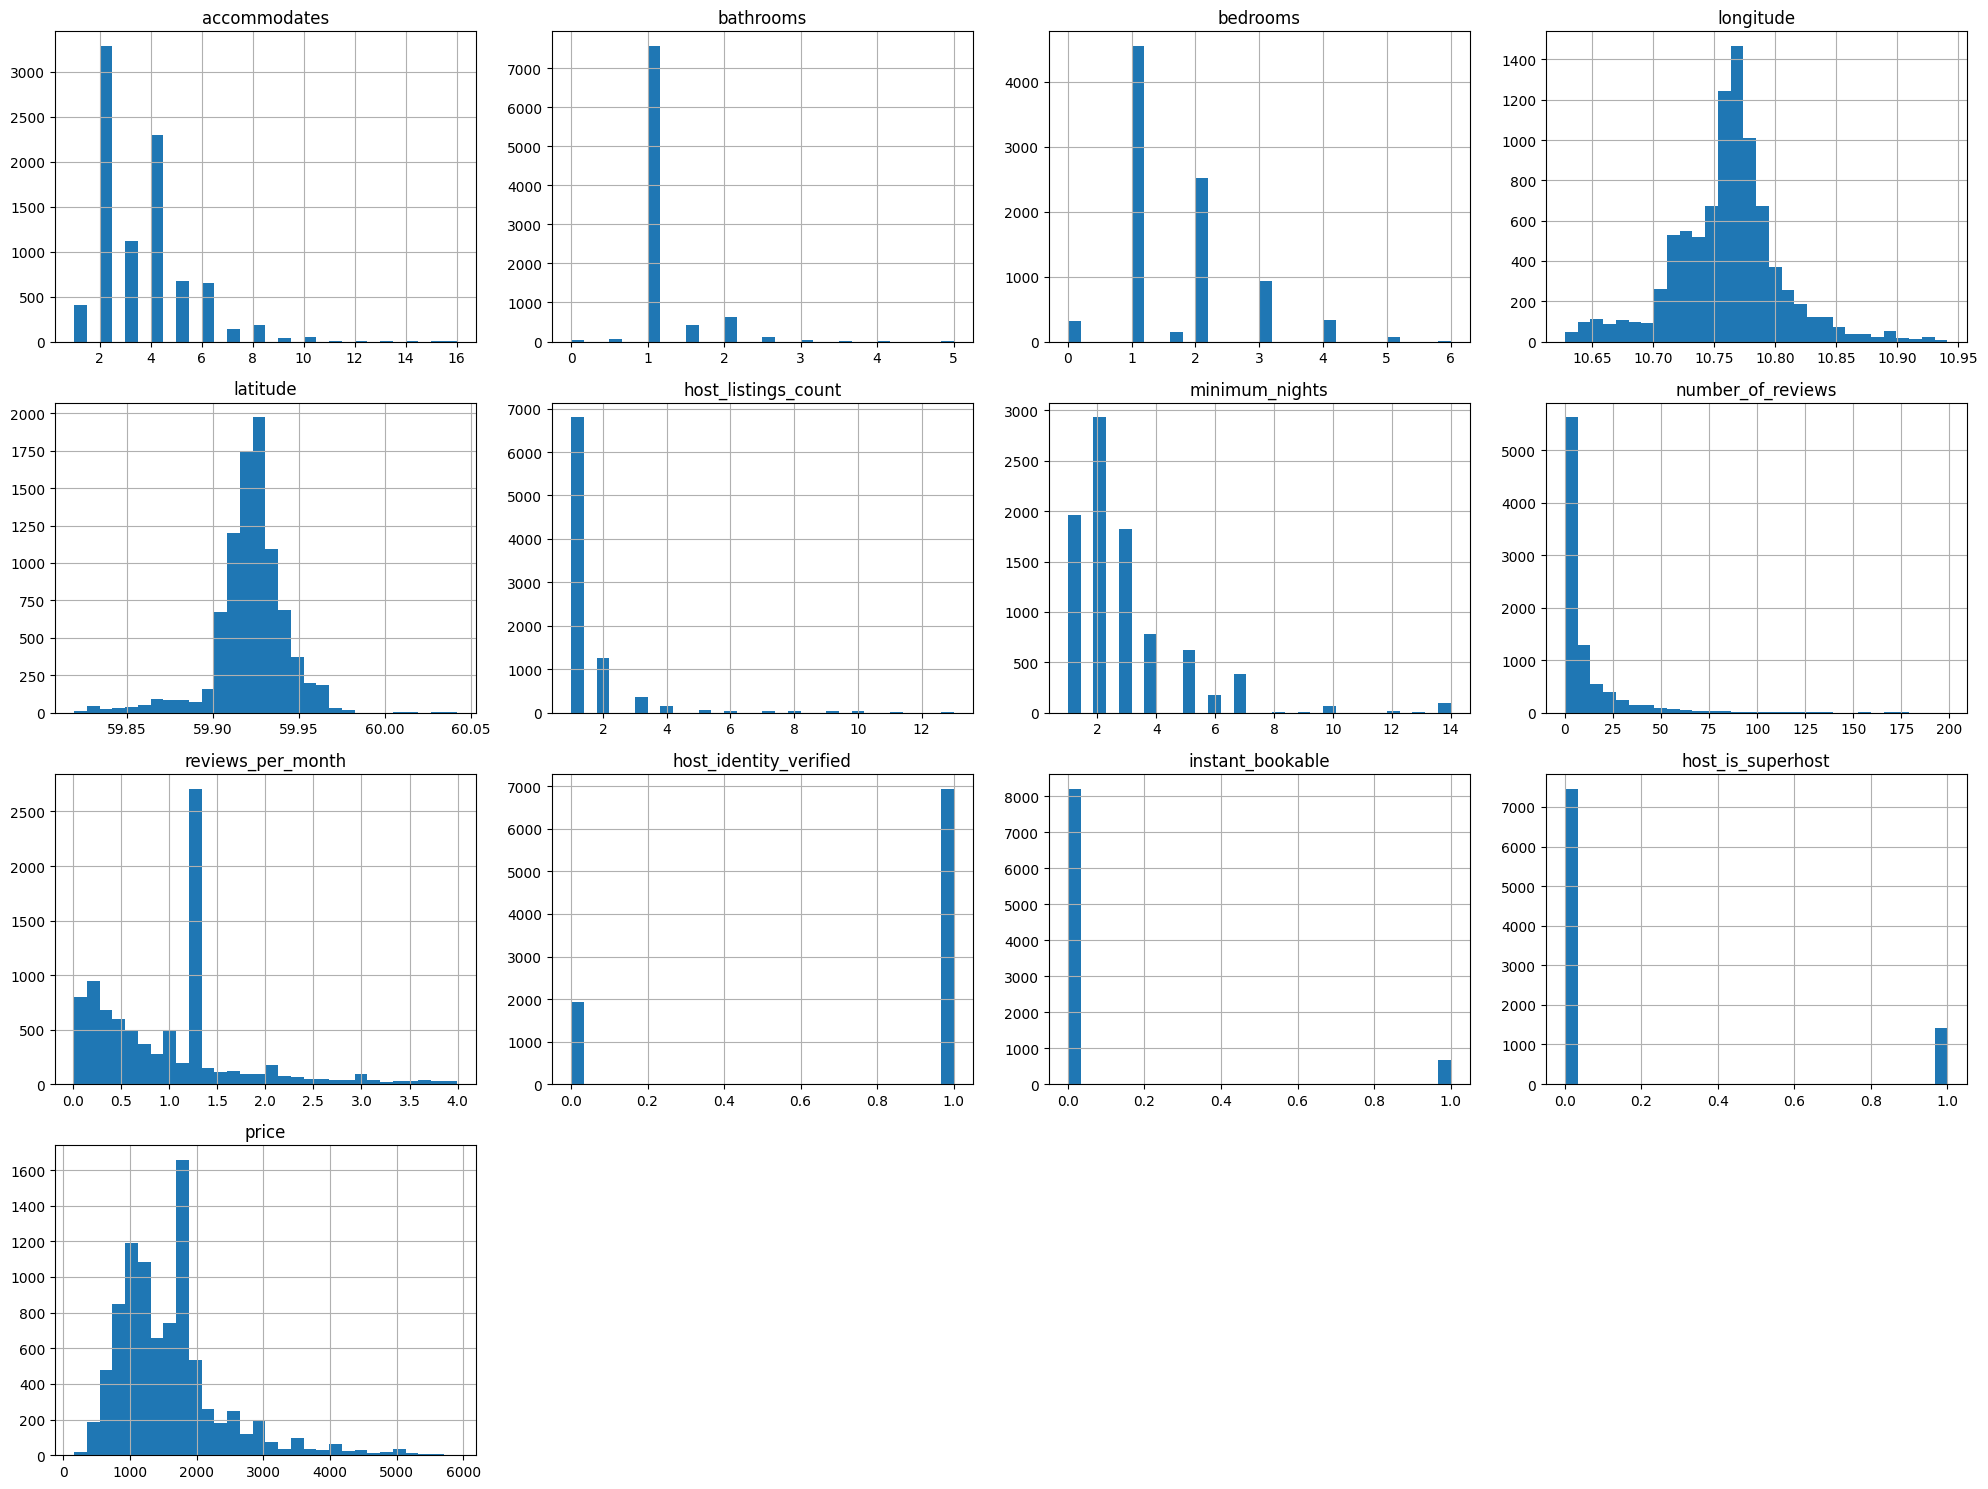

In [72]:
# Print the distribution of all the columns
df_cleaned.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()


# Deep learning model 


In [73]:
# Split the data into features and target

# Split the data into training and test sets where y is the price and X is the rest of the data
y = df_cleaned['price']
X = df_cleaned.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [74]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Hyper parameter search


In [75]:
# Define the parameter grid

# {'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}
# param_grid = {
#     'hidden_layer_sizes': [(32, 64), (32, 64, 32)],  
#     'activation': ['relu'],  
#     'solver': ['adam'], 
#     'learning_rate': ['adaptive',],  
#     'learning_rate_init': [0.01, 0.001], 
#     'batch_size': ['auto', 32, 64],  
#     'max_iter': [300]  
# }
param_grid = {
    'hidden_layer_sizes': [(32, 64)],  
    'activation': ['relu'],  
    'solver': ['adam'], 
    'learning_rate': ['adaptive',],  
    'learning_rate_init': [ 0.001], 
    'batch_size': [32],  
    'max_iter': [300]  
}

# Initialize the model
mlp_model = MLPRegressor(random_state=SEED)

# Initialize the grid search
grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, verbose=3)

# Fit the grid search to the data
grid_search_mlp.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/envs/applied-data-science/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, batch_size=32, hidden_layer_sizes=(32, 64), learning_rate=adaptive, learning_rate_init=0.001, max_iter=300, solver=adam;, score=0.438 total time=  18.9s


/opt/anaconda3/envs/applied-data-science/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, batch_size=32, hidden_layer_sizes=(32, 64), learning_rate=adaptive, learning_rate_init=0.001, max_iter=300, solver=adam;, score=0.435 total time=  22.6s


/opt/anaconda3/envs/applied-data-science/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, batch_size=32, hidden_layer_sizes=(32, 64), learning_rate=adaptive, learning_rate_init=0.001, max_iter=300, solver=adam;, score=0.484 total time=  30.2s


/opt/anaconda3/envs/applied-data-science/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, batch_size=32, hidden_layer_sizes=(32, 64), learning_rate=adaptive, learning_rate_init=0.001, max_iter=300, solver=adam;, score=0.440 total time=  42.3s


/opt/anaconda3/envs/applied-data-science/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, batch_size=32, hidden_layer_sizes=(32, 64), learning_rate=adaptive, learning_rate_init=0.001, max_iter=300, solver=adam;, score=0.434 total time=  21.4s


/opt/anaconda3/envs/applied-data-science/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPRegressor(random_state=42),
             param_grid={'activation': ['relu'], 'batch_size': [32],
                         'hidden_layer_sizes': [(32, 64)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.001], 'max_iter': [300],
                         'solver': ['adam']},
             verbose=3)

Best parameters found:  {'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}
Best R^2 score:  0.4461863435171393
R^2 on test set:  0.4666475167271401
RMSE on test set:  24.211030197097568
Mean absolute difference on test set :  413.4308954344473


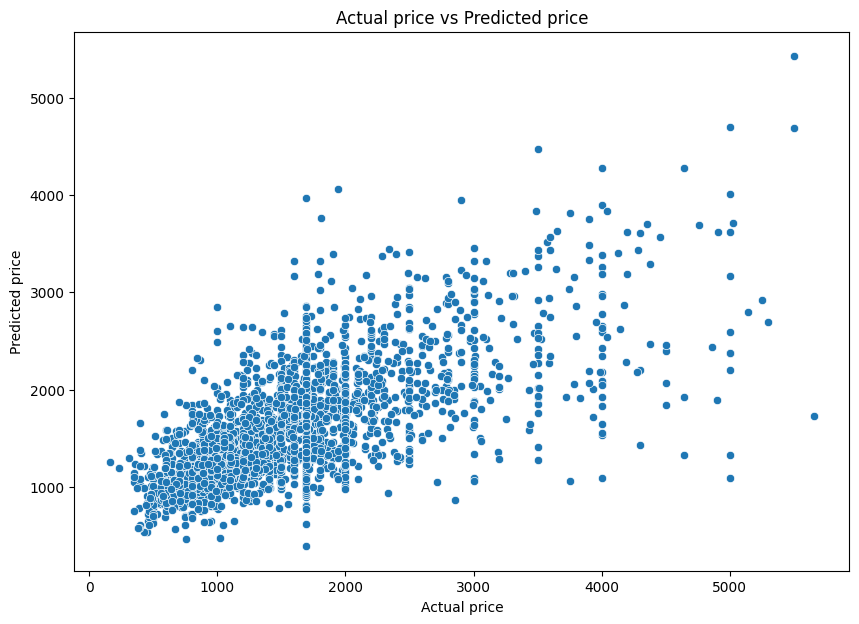

In [83]:
# Print the best parameters and the best score
print("Best parameters found: ", grid_search_mlp.best_params_)
print("Best R^2 score: ", grid_search_mlp.best_score_)

# Use the best estimator to make predictions
best_mlp_model = grid_search_mlp.best_estimator_
mlp_predictions = best_mlp_model.predict(X_test_scaled)

# Print the R^2 score on the test set
print("R^2 on test set: ", best_mlp_model.score(X_test_scaled, y_test))

# Print the RMSE on the test set
print("RMSE on test set: ", np.sqrt(root_mean_squared_error(y_test, mlp_predictions)))

# Print the mean absolute difference between the actual and predicted values
print("Mean absolute difference on test set : ", np.mean(np.abs(y_test - mlp_predictions)))

# Plot the predictions against the actual values
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=mlp_predictions)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual price vs Predicted price')
plt.show()





In [ ]:
# Print first 10 predictions
print("First 10 predictions: ", mlp_predictions[:10])
# Print first 10 actual values
print("First 10 actual values: ", y_test[:10].values)






First 10 predictions:  [2115.09331243  830.97574483 2906.05878254 1767.93899043 1099.11557322
 1444.99413976 1328.91084322 1754.34247072 1188.31167152 1615.41282064]
First 10 actual values:  [2157. 1400. 3000. 1970.  900. 1800. 2286. 1500. 1100. 2995.]
Mean absolute difference:  413.4308954344473
